# Optical Flow depth calculation

The procedure to claculate the depth map is as follows:
1. load up a video file and iterate over the frames
1. find the Aruco markers and calulate the coordinates of the centers
1. Using the markers find the locations of the Opitcal Flow zone centers (OFCn)
1. Calculate the dense optical flow of successive frames using Farneback algorithm
1. Extract the flow from the Optical Flow Zones (OFZn) and:
  1. remove outliers ( > than 1 stddev)
  1. find the mean value for each zone
1. 


In [1]:
user = 'gerrie'
#user = 'marcvanzyl'

In [2]:
import numpy as np
import cv2, os
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline

# The board
The following line of the board was updated to reflect the correct scale of the board.  This is necessary becuase the `board` object is used later   
`board = aruco.CharucoBoard_create(7, 5, .04026, .8*.04026, aruco_dict)`

Notice the board object returned.  Is contains all the magic of the CharUco pattern. For the image interpretation and to calibrate the cameras the cameras need a picture of the board and also information about the picture (ie. the details of the board).  This is all contained in the board object. 

In [3]:
board_size = 'experimental setup'

if board_size == '7x5':
    chessboard_num_squares_across = 7
    chessboard_num_squares_up = 5
    chessboard_square_size = 0.04026
    chessboard_aruco_ratio = 0.8   # this is a fraction of chessboard_square_size
    aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)


if board_size == '12x8':
    chessboard_num_squares_across = 12
    chessboard_num_squares_up = 8
    chessboard_square_size = 1
    chessboard_aruco_ratio = 0.7   # this is a fraction of chessboard_square_size
    aruco_dict = aruco.Dictionary_get(aruco.DICT_5X5_250)

elif board_size == 'experimental setup':   
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)





The board object contains all the vectors (pointing from the bottom left corner) to each of the corners present on the board.  The two kinds of objects are **aruco markers** and the **checkerboard**.  The aruco markers are called '`markers`' in the code and documentation.  The term `marker corners` means the set of 4 corners around each aruco maker. 

The aruco markers can be extracted from the board using the `aruco.getBoardObjectAndImagePoints(board, makerCorners command)`. 

Once the algorithm detected the markerCorners then it can interpolate between the marker corners to find the checkerboard corners.  The positions of checkerboard "inside" corners can be extracted using the folowing. 

The corners are labeled starting from 0 (bottom left) and going right 

### Now using Charuco

This function:
1. finds the locations of the corners of the aruco squares (`cv2.aruco.detectMarkers`)
1. if markers were found interpolates to find the checkerboard markers between them (`cv2.aruco.interpolateCornersCharuco`)
1. zooms into each checkerboard corner to get sub-pixel accuracy using (`cv2.cornerSubPix`)

In [4]:
def find_checkerboard_corners(img, board, clipLimit=2.0, verbose=False):

    # These are parameters used by the cv2.cornerSubPix function
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    # increase the contraxt
    img = increase_contrast(img, clipLimit=clipLimit)
 
    # convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    detect_params = aruco.CORNER_REFINE_SUBPIX

    # find the aruco corners and the ids of each corner
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict, detect_params)
    
    if verbose:
        print('Found {} aruco marker corners'.format(len(ids)))
    
    if len(ids)>0:
        (retval, charucoCorners,
         charucoIds) = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board, )
        if verbose:
            print('Found {} checker corners'.format(len(charucoIds)))
        if len(charucoIds)>0:
            # SUB PIXEL DETECTION
            for corner in charucoCorners:
                if verbose:
                    print('Sub pixel optimization:')
                    print(corner)
                cv2.cornerSubPix(gray, corner,
                                 winSize = (5,5),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
                if verbose:
                    print(corner)
                    print('+++')
        
    return charucoCorners, charucoIds, gray.shape

        

One big problem is that you need to give the stereo calibration only coners that appear in both cameras.  Fortunately, the detection returns the ids of the corners in the `charucoIds`. These `charucoIds` correspond to the numbering system mentioned above (bottom left is 0 and starts going across to the right)

In [5]:
import pickle
# load the camera calibration data
cam_calOF = pickle.load( open('OFCameraCalibration.p', 'rb'))



In [6]:
cam_calOF.keys()

dict_keys(['camera_name', 'ret', 'mtx', 'dist', 'rvecs', 'tvecs'])

# Now we can check

## Camera features:
- sensor size = 3.68 x 2.76 mm  
- sensor resolution  = 3280 × 2464
- focal length = 3.04 mm

$$ d_{mm} = \frac{pix \times 3.68}{3280} $$

The depth can now be found
$$ Z = \frac{T \times f}{d_{mm}} $$

In [7]:
import pandas as pd

In [8]:
# adapted from here https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
def increase_contrast(img, clipLimit=3.0, verbose=False):

    if clipLimit>0.0:
        #-----Converting image to LAB Color model----------------------------------- 
        lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        if verbose:
            cv2.imshow("lab",lab)

        #-----Splitting the LAB image to different channels-------------------------
        l, a, b = cv2.split(lab)
        if verbose:
            cv2.imshow('l_channel', l)
            cv2.imshow('a_channel', a)
            cv2.imshow('b_channel', b)

        #-----Applying CLAHE to L-channel-------------------------------------------
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(8,8))
        cl = clahe.apply(l)
        if verbose:
            cv2.imshow('CLAHE output', cl)

        #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
        limg = cv2.merge((cl,a,b))
        if verbose:
            cv2.imshow('limg', limg)

        #-----Converting image from LAB Color model to RGB model--------------------
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        if verbose:
            cv2.imshow('final', final)
    else:
        final = img.copy()

    return final

In [9]:
# finds the corners of all teh identifiable Aruco markers

def find_charuco_marker_corners(img, aruco_dict, clipLimit=3.0, verbose=False):

    # These are parameters used by the cv2.cornerSubPix function
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 1e-11)

    # increase the contraxt
    img = increase_contrast(img, clipLimit=clipLimit)


 
    # convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

    # find the aruco corners and the ids of each corner
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)

    if verbose:
        print('Found {} aruco marker corners'.format(len(ids)))
        
    
    #  now find the central points of the aruco markers by averaging the four corner points
    if  len(ids) > 0:
        # SUB PIXEL DETECTION
        for corner in corners:
            if verbose:
                print('Sub pixel optimization:')
                print(corner)
            cv2.cornerSubPix(gray, corner,
                             winSize = (4,4),
                             zeroZone = (-1,-1),
                             criteria = criteria)
            if verbose:
                print(corner)
                print('+++')




    return np.array(corners), ids, gray.shape

        

In [10]:
def find_aruco_center(corners, ids):
    # find the center point of the 4 corner of the aruco markers
    centers = []
    for cnrs in corners:
        center = np.array((np.average(cnrs[0][:,0]), np.average(cnrs[0][:,1])))
        centers.append(center)
    centers = np.array(centers)
    centers = np.array(centers).reshape((-1,1,2))
    center_ids = np.arange(centers.shape[0]).reshape(-1,1)
    
    return centers, ids

In [11]:
image_number = 0

# Load the list of files

In [12]:
datadir = "/Users/{}/Google Drive/ScienceFair2021/DataCapture/smooth/".format(user)


video_files = np.array([f for f in os.listdir(datadir) if f.endswith(".mp4") ])

# just sorts the files according to the number so we match picture 1_A with 1_C etc
#orderR = np.argsort([int((p.split('_')[-1]).split('.')[0]) for p in video_files])
#video_files = video_files[orderR]
video_files.sort()

In [13]:
video_files.shape

(80,)

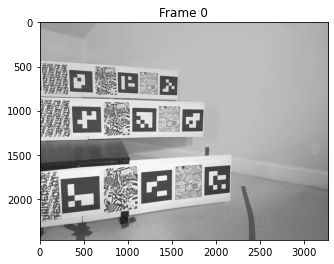

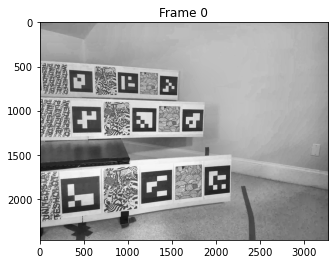

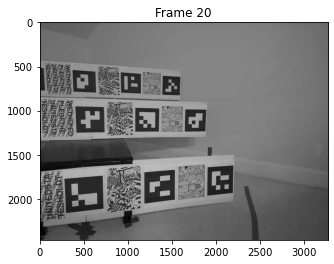

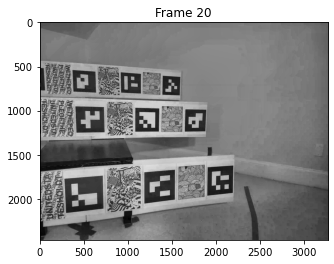

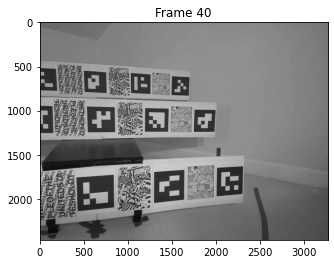

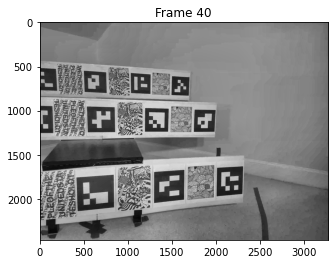

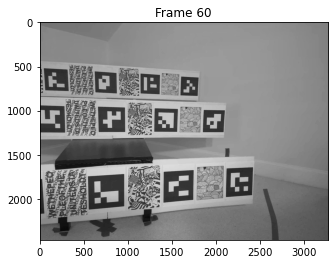

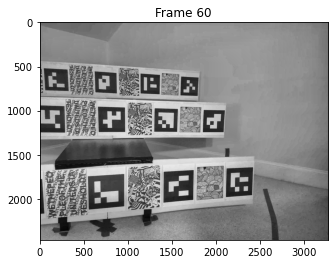

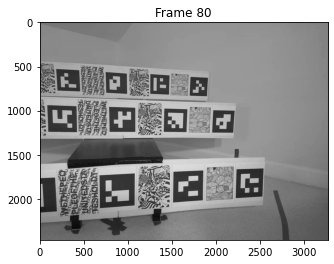

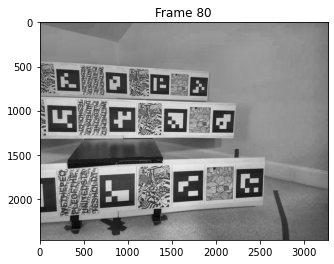

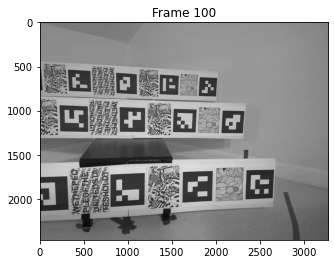

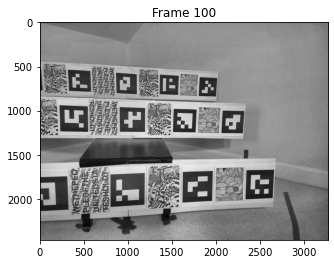

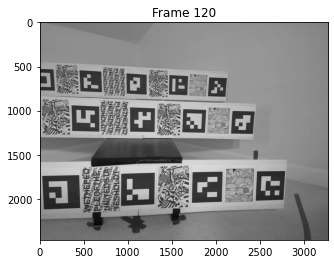

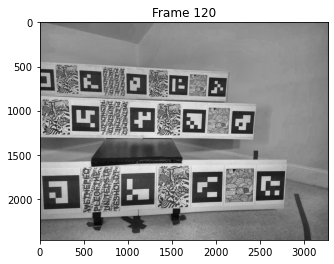

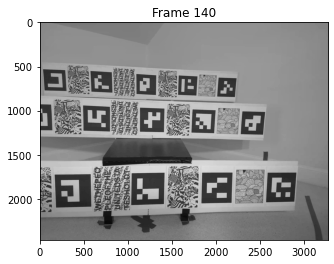

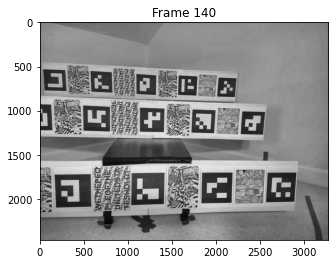

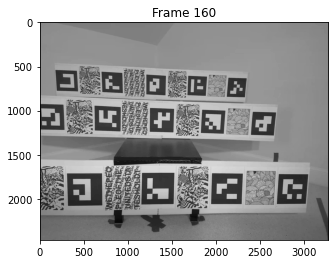

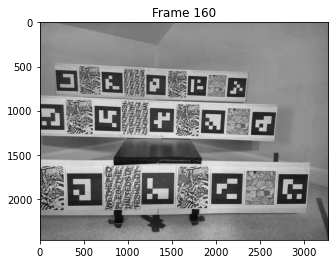

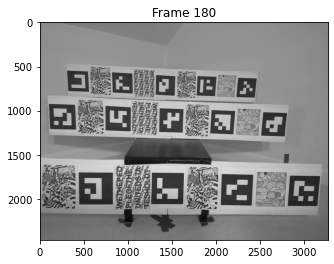

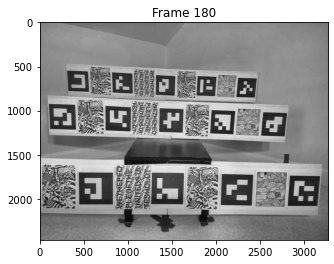

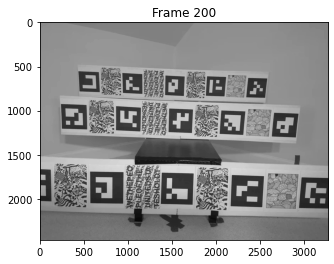

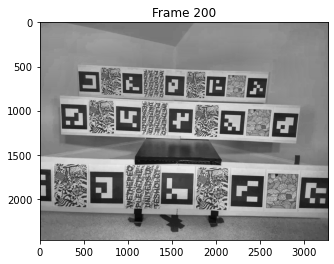

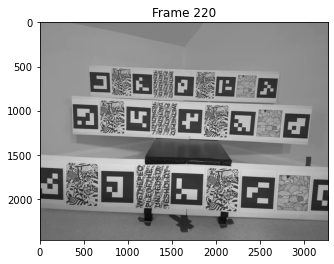

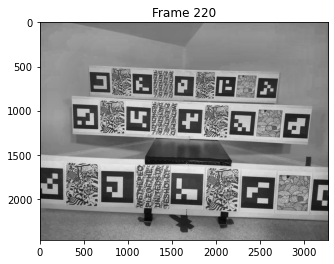

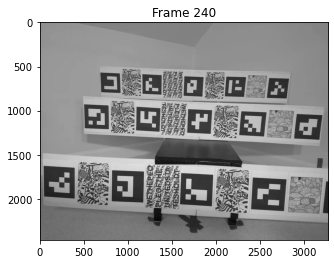

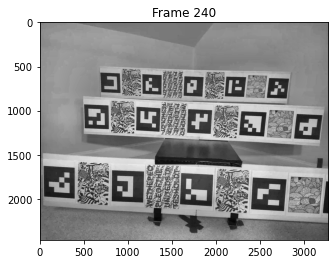

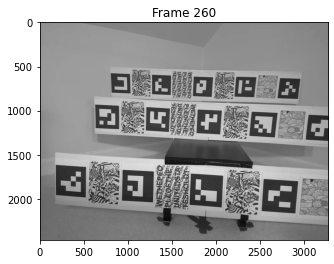

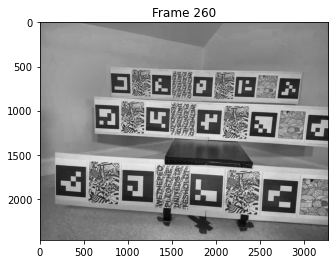

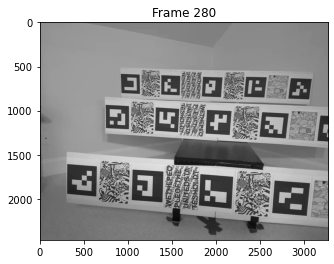

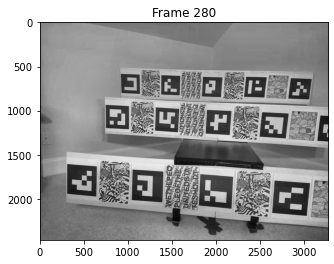

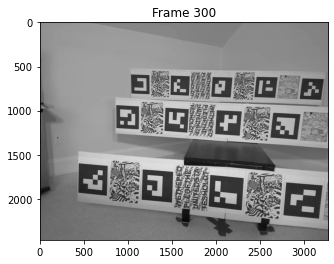

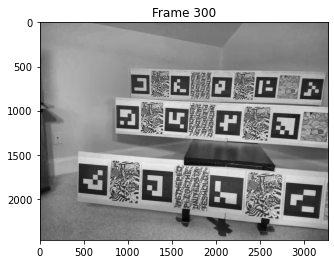

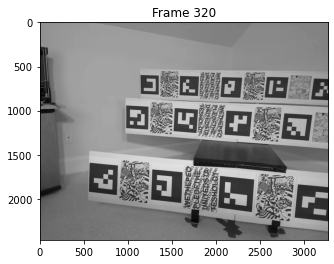

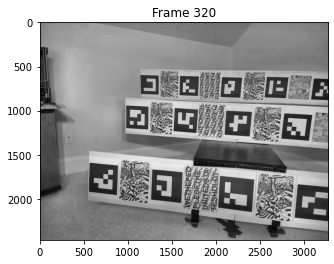

Done!


In [14]:
video_capture = cv2.VideoCapture('{}{}'.format(datadir, video_files[1]))
#video_capture.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'h264'))

video_capture.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'H264'))

frame = 0
while video_capture.isOpened():
    ret, image = video_capture.read()
    
    
    if not ret:
        break
    if frame%20 == 0:
        image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        plt.imshow(image2,cmap='gray')
        plt.title('Frame {}'.format(frame))
        plt.show()
        plt.imshow(cv2.cvtColor(increase_contrast(image, clipLimit=2.0, verbose=False), cv2.COLOR_BGR2GRAY),cmap='gray')
        plt.title('Frame {}'.format(frame))
        plt.show()
    frame += 1
print('Done!')

# Run the analysis

In [15]:
# function to find the centers of the optical flow zones
# sometimes an aruco marker may be outside of the view, then extrapolate to find the location
def find_target_centers(sorted_centers, sorted_center_ids):
    front_row = [1,2,3] # the OFZones in the front row are located between aruco id 1 and 2 and 2 and 3
    middle_row = [6,7,8]
    back_row = [11, 12, 13]
    results = []

    rows = [{'row':'front', 'aruco_ids':front_row}, {'row':'middle', 'aruco_ids':middle_row}, {'row':'back', 'aruco_ids':back_row}]

    for row in rows:
        result_row = row.copy()

        aruco_target = row['aruco_ids']
        
        # need to check we have 2 of three aruco_ids per row
        ids_count = 0
        for ids in aruco_target:
            if ids in sorted_center_ids:
                ids_count += 1

        if ids_count > 1:
            if aruco_target[1] in sorted_center_ids:
                if aruco_target[0] in sorted_center_ids:
                    # calc by interpolation
                    target_l = (sorted_centers[np.where(sorted_center_ids==aruco_target[1])] + sorted_centers[np.where(sorted_center_ids==aruco_target[0])])/2
                else:
                    # calc by extrapolation
                    target_l = ( sorted_centers[np.where(sorted_center_ids==aruco_target[1])] -
                     (sorted_centers[np.where(sorted_center_ids==aruco_target[2])] - sorted_centers[np.where(sorted_center_ids==aruco_target[1])])/2)

                if aruco_target[2] in sorted_center_ids:
                    target_r = (sorted_centers[np.where(sorted_center_ids==aruco_target[2])] + sorted_centers[np.where(sorted_center_ids==aruco_target[1])])/2   
                else:
                    target_r = ( sorted_centers[np.where(sorted_center_ids==aruco_target[1])] +
                     (sorted_centers[np.where(sorted_center_ids==aruco_target[1])] - sorted_centers[np.where(sorted_center_ids==aruco_target[0])])/2)
            else:  # we have [0] and [2]
                delta = (sorted_centers[np.where(sorted_center_ids==aruco_target[2])] - sorted_centers[np.where(sorted_center_ids==aruco_target[0])])/4
                
                target_l = sorted_centers[np.where(sorted_center_ids==aruco_target[0])] + delta

                target_r = sorted_centers[np.where(sorted_center_ids==aruco_target[0])] + 3*delta
                
                
            result_row['left_zone_center'] = target_l.reshape(2)
            result_row['right_zone_center'] = target_r.reshape(2)
        
        else:
            result_row['left_zone_center'] = np.array([np.nan,np.nan])
            result_row['right_zone_center'] = np.array([np.nan,np.nan])



        results.append(result_row)
    return results

In [16]:
# remove outliers using statistics 
def clean_OF(of_array, std=2):
    
    of_x = of_array[:,:,0]
    mean_x = np.nanmean(of_x)
    std_x = np.std(of_x)
    
    # create boolean arrays of where the readings are out-of-bounds
    flow_too_large = of_x > mean_x + std*std_x
    flow_too_small = of_x < mean_x - std*std_x

    # create a copy of flow_x
    cleaned_flow_x = of_x.copy()
    # set all the our-of-bound elements to np.NaN
    cleaned_flow_x[np.logical_or(flow_too_large, flow_too_small)] = np.nan

    return cleaned_flow_x

In [17]:
def read_frame(handle, counter):
    counter += 1    
    ret, frame = handle.read()    
    return ret, frame, counter


def get_frame(handle, counter):
    counter += 1
    ret = handle.grab()
    return ret, counter

import math

# Process File with Frame interleave

In [18]:
def read_frame(handle, counter):
    counter += 1    
    ret, frame = handle.read()    
    return ret, frame, counter


def get_frame(handle, counter):
    counter += 1
    ret = handle.grab()
    return ret, counter

import math

In [80]:
#New version that interleaves frames
def process_file2(file_path, 
                 skip_frames=4,
                 mean_pixels=120, 
                 verbose=0,
                 grabframe=-1):
    
    result_list = []

    counter = 0
    result_df = pd.DataFrame(columns=['AM0','AM1','AM2','AM3','AM4','AM5','AM6','AM7','AM8','AM9','AM10','AM11','AM12','AM13','AM14',
                                     'OFC0', 'OFC1', 'OFC2', 'OFC3', 'OFC4', 'OFC5',
                                     'OFZ0','OFZ1','OFZ2','OFZ3','OFZ4','OFZ5'])
    
    pics = [] # list to hold copies of the skipped frames
    
    # the size of the square to average the flow over
    center_range = mean_pixels

    cap = cv2.VideoCapture(file_path)
    print("Working with: {}".format(file_path))
    
    # Thresholds to extract the right frames
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    mid = num_frames/2
    lower_bound = int(21) # drops the first 25% frames
    upper_bound = int(num_frames-21) # drops the last 25% second
    print('Frames: {}  mid: {} lower: {} uuper: {}'.format(num_frames, mid, lower_bound, upper_bound))

    
    # skip the initial frames
    for _ in range(lower_bound):
        ret, counter = get_frame(cap, counter)
    
    # initialize the pics list with frames
    
    # Get first frame
    ret, frame0, counter = read_frame(cap, counter)
    frame0_color = cv2.undistort(frame0,cam_calOF['mtx'],cam_calOF['dist'],None)
    frame0_gray = cv2.cvtColor(frame0_color,cv2.COLOR_BGR2GRAY)
    pics.append(frame0_gray)
    
    # initialze the array of flows
    flow = np.zeros_like(frame0)
    flags = 0
    
    for i in range(skip_frames-1):
        # read the frames
        ret, frame1, counter = read_frame(cap, counter)
        current_pic_color = cv2.undistort(frame1,cam_calOF['mtx'],cam_calOF['dist'],None)
        current_pic_gray = cv2.cvtColor(current_pic_color,cv2.COLOR_BGR2GRAY)
        pics.append(current_pic_gray)  

        flow = cv2.calcOpticalFlowFarneback(pics[0], current_pic_gray, flow, 0.5, 3, 50, 6, 7, 1.5, flags)
        flags = cv2.OPTFLOW_USE_INITIAL_FLOW

        

    # this creates the array for the sorted centers 
    sorted_centers = np.zeros([10,2])
    


    while(counter < upper_bound):
        
        # read a frame
        ret, curr_pic_color, counter = read_frame(cap, counter)

        curr_pic_color = cv2.undistort(curr_pic_color,cam_calOF['mtx'],cam_calOF['dist'],None)
        curr_pic_grey = cv2.cvtColor(curr_pic_color, cv2.COLOR_BGR2GRAY)

        #flow[:,:,1] = 0


        flow = cv2.calcOpticalFlowFarneback(pics[0], curr_pic_grey, flow, 0.5, 3, 50, 6, 7, 1.5, flags)

        if verbose>0:
            print('Image Frame Number: {}'.format(counter))


        # find the four corners of each aruco marker
        arucoCorners, arucoIds, imsize =  find_charuco_marker_corners(curr_pic_color, 
                                                            aruco_dict, clipLimit=2.0, 
                                                            verbose=False)

        # now find the center point of each aruco marker 
        centers, center_ids = find_aruco_center(arucoCorners, arucoIds)

        # next sort the centers by center_ids from 0 to 9
        center_ids = center_ids.reshape(-1)
        centers = centers.reshape(-1,2)
        if verbose>1:  
            print('CenterIds {}'.format(center_ids))

        # insert the centers into the sorted centers array in the right order
        arr1inds = center_ids.argsort()
        sorted_centers = centers[arr1inds]
        sorted_center_ids = center_ids[arr1inds] 
        
        # add sorted centers to the frame results series
        frame_res = pd.Series(index=['AM0','AM1','AM2','AM3','AM4','AM5','AM6','AM7','AM8','AM9','AM10','AM11','AM12','AM13','AM14',
                                     'OFC0', 'OFC1', 'OFC2', 'OFC3', 'OFC4', 'OFC5',
                                     'OFZ0','OFZ1','OFZ2','OFZ3','OFZ4','OFZ5' ], dtype=object)
        
        # save the aruco marker centers to the series
        for ind, ids in enumerate(sorted_center_ids):
            frame_res['AM{}'.format(ids)] = sorted_centers[ind]
            
        frame_result_list = []
        
        # find the centers of all the target zones
        targets = find_target_centers(sorted_centers, sorted_center_ids)
        """
        {'row': 'front',
          'aruco_ids': [1, 2, 3],
          'left_zone_center': array([2208.1284, 2125.8706], dtype=float32),
          'right_zone_center': array([3100.6724, 2243.5234], dtype=float32)}
          """
        of_zone_number = 0
        
        for row in targets:
            frame_res['OFC{}'.format(of_zone_number)] = row['left_zone_center']
            frame_res['OFZ{}'.format(of_zone_number)] = 777 #get_cleaned_OF(flow, center, pixels)

            of_zone_number += 1       
            
            frame_res['OFC{}'.format(of_zone_number)] = row['right_zone_center']
            frame_res['OFZ{}'.format(of_zone_number)] = 777 #get_cleaned_OF(flow, center, pixels)

            of_zone_number += 1


        
        
        # extract the optical flow in the areas around the target zones
        for of_center in frame_res[frame_res.index.str.contains('OFC')].index:
            center = frame_res[of_center]
            
            if verbose>1:
                print('OFCenter {} : {} - flow.shape {}'.format(of_center, center, flow.shape))
            
            center_x = center[0]
            center_y = center[1]
            
            if not (math.isnan(center_x) or math.isnan(center_y)):
                sub_OF_array = flow[int(center_y-mean_pixels/2):int(center_y+mean_pixels/2), 
                                    int(center_x-mean_pixels/2):int(center_x+mean_pixels/2), :]
                

                # extract x component of OF and clean the optical flow 
                cleaned_of_x = clean_OF(sub_OF_array, std=2)

                # find the mean of the optical flow in x and y
                mean_of_x = np.nanmean(cleaned_of_x)/skip_frames


                # save the results in a df

                frame_res['OFZ{}'.format(of_center[3:])] = mean_of_x
            else: 
                print('WARNING: Nan OF center')
                frame_res['OFZ{}'.format(of_center[3:])] = np.nan
        
        if verbose>0:
            print(frame_res) 
            print('Skip frame length: {}'.format(len(pics)))


        result_df.loc[counter] = frame_res

        if verbose>1:
            
            hsv = np.zeros_like(frame1)
            hsv[...,1] = 255


            x = sorted_centers[:,0]
            y = sorted_centers[:,1]
            mag = (cv2.multiply(cv2.add(flow[...,0],-10),5))

            mag[mag<0.0] = 0
            mag[mag>255] = 255

            print("mean: {} max: {}  min: {} {}".format(mag.mean(), mag.max(), mag.min(), flow.shape))

            # edge detection for the outlines
            edges = cv2.Canny(curr_pic_color, 50, 100)


            hsv[...,0] = 0
            #hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
            hsv[...,2] = mag
            rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

            annot_font = {'fontname':'Arial', 'size':'14','weight':'bold'}

            fig, axs = plt.subplots(figsize=(36,24))
            rgb[edges>100,1] = 255 
            axs.imshow(rgb)
            axs.scatter(x,y, color='r')
            for i, ids in enumerate(sorted_center_ids):
                axs.annotate('{}'.format(int(ids)), (x[i]+20, y[i]+30), color='r',  **annot_font)
                
            for ind in frame_res[frame_res.index.str.contains('OFC')].index:
                axs.annotate('{}'.format(ind), frame_res[ind], color='w', **annot_font)

            plt.show()
            
            if counter == grabframe:  # this is a hack to save a particular image set
                save_dict = {}
                save_dict['filename'] = file_path
                save_dict['frame'] = counter
                save_dict['img'] = curr_pic_grey

                save_dict['flow'] = flow

                save_dict['centers'] = sorted_centers

                save_dict['center_ids'] = sorted_center_ids

                save_dict['frame_res'] = frame_res


                pickle.dump(save_dict, open('{}frame_results.p'.format(datadir), 'wb'))
                
        pics.append(curr_pic_grey) # add the current image to end
        
        # cycle the stored frames
        for i in range(skip_frames):
            pics[i] = np.copy(pics[i+1])
        pics.pop(-1) # remove the last item
        
        
        
    #pickle.dump(result_df, open('{}{}_res.p'.format(datadir, file[:-5]), 'wb'))
    return result_df

In [20]:
frame_res = pd.Series(index=['AM0','AM1','AM2','AM3','AM4','AM5','AM6','AM7','AM8','AM9','AM10','AM11','AM12','AM13','AM14',
                                     'OFC0', 'OFC1', 'OFC2', 'OFC3', 'OFC4', 'OFC5',
                                     'OFZ0','OFZ1','OF20','OFZ3','OFZ4','OFZ5' ], dtype=object)

0


In [24]:
video_files

array(['Smooth_15_-2_0_4623HF.mp4', 'Smooth_15_-2_1_QV4WNZ.mp4',
       'Smooth_15_-2_2_JB90U4.mp4', 'Smooth_15_-2_3_MCDNNA.mp4',
       'Smooth_15_-2_4_VIWO2O.mp4', 'Smooth_15_-4_0_ESS22N.mp4',
       'Smooth_15_-4_1_8GD6QO.mp4', 'Smooth_15_-4_2_FMBNMX.mp4',
       'Smooth_15_-4_3_EEUONU.mp4', 'Smooth_15_-4_4_64CXH3.mp4',
       'Smooth_15_-6_0_2HDNNZ.mp4', 'Smooth_15_-6_1_D23FV7.mp4',
       'Smooth_15_-6_2_U8BJY4.mp4', 'Smooth_15_-6_3_GK86VH.mp4',
       'Smooth_15_-6_4_JU8DFH.mp4', 'Smooth_15_0_0_D26LA1.mp4',
       'Smooth_15_0_1_OOBKBZ.mp4', 'Smooth_15_0_2_MNBSLT.mp4',
       'Smooth_15_0_3_VY12DF.mp4', 'Smooth_15_0_4_46CIDO.mp4',
       'Smooth_30_-2_0_07HKRJ.mp4', 'Smooth_30_-2_1_UA678T.mp4',
       'Smooth_30_-2_2_Z2CEPT.mp4', 'Smooth_30_-2_3_DPNF63.mp4',
       'Smooth_30_-2_4_O2G6SZ.mp4', 'Smooth_30_-4_0_9WKFQF.mp4',
       'Smooth_30_-4_1_B6QVWT.mp4', 'Smooth_30_-4_2_9YG7KZ.mp4',
       'Smooth_30_-4_3_ZZ3YEH.mp4', 'Smooth_30_-4_4_ARXESZ.mp4',
       'Smooth_30_-6_0_HOA2A3.

In [121]:
video_files[-12]

'Smooth_60_-4_3_DDB2LK.mp4'

In [151]:
# set verbose = True to make plots of each frame
verbose = 1
file  = video_files[-1]
res0 = process_file2(datadir+file, skip_frames=1, mean_pixels=120, verbose=verbose)

file  = video_files[-18]
res2 = process_file2(datadir+file, skip_frames=1, mean_pixels=120, verbose=verbose)

file  = video_files[-11]
res4 = process_file2(datadir+file, skip_frames=1, mean_pixels=120, verbose=verbose)

file  = video_files[-8]
res6 = process_file2(datadir+file, skip_frames=1, mean_pixels=120, verbose=verbose)

Working with: /Users/gerrie/Google Drive/ScienceFair2021/DataCapture/smooth/Smooth_60_-2_4_UX8ITL.mp4
Frames: 135  mid: 67.5 lower: 21 uuper: 114
Image Frame Number: 23
AM0                        NaN
AM1                        NaN
AM2     [938.13556, 1890.9601]
AM3     [1727.9728, 1871.4927]
AM4     [2439.6423, 1850.2292]
AM5                        NaN
AM6      [400.2244, 1097.8411]
AM7      [1033.2872, 1109.384]
AM8     [1621.2605, 1122.3495]
AM9       [2172.31, 1140.3893]
AM10                       NaN
AM11     [490.64453, 684.7514]
AM12      [998.7516, 710.8904]
AM13     [1469.6416, 720.6371]
AM14      [1910.2026, 743.064]
OFC0     [543.2169, 1900.6938]
OFC1    [1333.0542, 1881.2263]
OFC2     [716.7558, 1103.6125]
OFC3    [1327.2739, 1115.8667]
OFC4     [744.69806, 697.8209]
OFC5    [1234.1965, 715.76373]
OFZ0                    10.274
OFZ1                    9.1339
OFZ2                   9.33532
OFZ3                   8.55564
OFZ4                   8.61577
OFZ5                   8.

Image Frame Number: 32
AM0                        NaN
AM1                        NaN
AM2     [1024.4166, 1887.4688]
AM3     [1808.2584, 1871.9623]
AM4     [2521.2407, 1856.4164]
AM5                        NaN
AM6      [485.0038, 1097.9044]
AM7     [1108.2953, 1110.4489]
AM8      [1692.7755, 1124.291]
AM9     [2244.1636, 1143.4089]
AM10                       NaN
AM11     [567.20416, 687.9799]
AM12     [1068.3701, 713.6325]
AM13     [1536.1523, 722.9802]
AM14     [1976.0288, 745.0913]
OFC0     [632.4957, 1895.2219]
OFC1    [1416.3375, 1879.7156]
OFC2    [796.64954, 1104.1766]
OFC3    [1400.5354, 1117.3699]
OFC4      [817.7871, 700.8062]
OFC5     [1302.2612, 718.3064]
OFZ0                   9.57305
OFZ1                   8.62291
OFZ2                   8.26092
OFZ3                   7.67744
OFZ4                   7.52527
OFZ5                   7.07072
dtype: object
Skip frame length: 1
Image Frame Number: 33
AM0                        NaN
AM1                        NaN
AM2     [1033.3292, 

Image Frame Number: 42
AM0                        NaN
AM1     [286.82272, 1902.7996]
AM2          [1120.0, 1883.75]
AM3     [1899.3676, 1874.8926]
AM4     [2615.0674, 1864.3889]
AM5                        NaN
AM6      [578.2836, 1098.2891]
AM7          [1192.25, 1112.0]
AM8      [1773.763, 1126.8611]
AM9     [2326.6377, 1147.1288]
AM10      [137.59874, 673.454]
AM11       [652.9734, 691.611]
AM12          [1147.0, 717.25]
AM13      [1611.137, 725.6653]
AM14     [2050.9504, 747.4232]
OFC0     [703.4114, 1893.2748]
OFC1    [1509.6838, 1879.3213]
OFC2    [885.26685, 1105.1445]
OFC3    [1483.0065, 1119.4305]
OFC4     [899.9867, 704.43054]
OFC5    [1379.0685, 721.45764]
OFZ0                   10.1511
OFZ1                   9.23118
OFZ2                   9.25204
OFZ3                   8.56469
OFZ4                   8.98154
OFZ5                    8.4681
dtype: object
Skip frame length: 1
Image Frame Number: 43
AM0                        NaN
AM1     [298.82745, 1901.7073]
AM2          [1130.0

Image Frame Number: 52
AM0                        NaN
AM1       [397.744, 1894.0698]
AM2     [1216.9518, 1882.2118]
AM3      [1992.281, 1878.9303]
AM4     [2712.0881, 1873.3586]
AM5                        NaN
AM6       [671.816, 1098.5503]
AM7     [1278.0166, 1113.2123]
AM8     [1856.7189, 1129.3936]
AM9     [2411.7092, 1151.2047]
AM10      [228.75983, 677.448]
AM11     [738.0863, 694.94763]
AM12     [1225.6221, 719.4142]
AM13    [1687.6718, 727.96765]
AM14     [2127.9172, 749.7522]
OFC0     [807.3479, 1888.1409]
OFC1     [1604.6165, 1880.571]
OFC2    [974.91626, 1105.8813]
OFC3     [1567.3677, 1121.303]
OFC4      [981.8542, 707.1809]
OFC5      [1456.647, 723.6909]
OFZ0                   9.47628
OFZ1                    8.7399
OFZ2                   8.01316
OFZ3                   7.58556
OFZ4                   7.30142
OFZ5                   6.93341
dtype: object
Skip frame length: 1
Image Frame Number: 53
AM0                        NaN
AM1     [407.87802, 1893.5042]
AM2     [1225.9714, 

Image Frame Number: 62
AM0                        NaN
AM1     [504.48325, 1886.6764]
AM2      [1311.8988, 1881.411]
AM3     [2085.2014, 1883.5706]
AM4     [2810.2378, 1883.2122]
AM5                        NaN
AM6      [762.2695, 1099.0487]
AM7         [1361.25, 1115.25]
AM8     [1938.6877, 1132.0494]
AM9      [2496.6934, 1155.089]
AM10     [320.67938, 681.4993]
AM11      [820.6742, 698.2248]
AM12     [1303.0118, 722.1595]
AM13    [1763.1495, 730.26154]
AM14    [2204.5195, 751.61365]
OFC0    [908.19104, 1884.0437]
OFC1      [1698.55, 1882.4907]
OFC2    [1061.7598, 1107.1494]
OFC3    [1649.9689, 1123.6497]
OFC4     [1061.843, 710.19214]
OFC5     [1533.0807, 726.2105]
OFZ0                   10.4265
OFZ1                   9.78119
OFZ2                    9.2783
OFZ3                   8.85278
OFZ4                   8.54952
OFZ5                   8.19864
dtype: object
Skip frame length: 1
Image Frame Number: 63
AM0                        NaN
AM1      [515.2051, 1886.0703]
AM2     [1321.7642, 

Image Frame Number: 72
AM0                        NaN
AM1        [604.7115, 1881.18]
AM2     [1402.9532, 1881.4441]
AM3     [2175.5503, 1888.9644]
AM4     [2907.3423, 1893.6703]
AM5     [231.18745, 1081.6516]
AM6     [848.09485, 1099.7936]
AM7     [1441.6074, 1116.5907]
AM8     [2018.5745, 1135.0253]
AM9     [2580.4792, 1159.4136]
AM10     [407.06448, 684.9296]
AM11    [899.25806, 701.30505]
AM12     [1377.0723, 724.5047]
AM13     [1836.2649, 732.2919]
AM14     [2279.392, 753.32886]
OFC0     [1003.8324, 1881.312]
OFC1    [1789.2517, 1885.2042]
OFC2    [1144.8511, 1108.1921]
OFC3      [1730.091, 1125.808]
OFC4     [1138.1652, 712.9049]
OFC5     [1606.6686, 728.3983]
OFZ0                   9.24081
OFZ1                    8.8886
OFZ2                   7.85876
OFZ3                   7.68963
OFZ4                   7.13702
OFZ5                   6.94321
dtype: object
Skip frame length: 1
Image Frame Number: 73
AM0                        NaN
AM1     [614.57916, 1880.7819]
AM2     [1411.8287, 

Image Frame Number: 82
AM0                        NaN
AM1     [708.09894, 1876.3407]
AM2      [1497.8071, 1882.668]
AM3     [2271.5178, 1896.1407]
AM4         [3011.25, 1905.75]
AM5      [330.8793, 1081.8419]
AM6     [937.31213, 1101.0325]
AM7     [1525.9106, 1118.6267]
AM8     [2103.4893, 1138.2467]
AM9     [2670.5317, 1164.1951]
AM10    [496.55106, 688.77295]
AM11      [980.9972, 704.4233]
AM12     [1454.7544, 727.0584]
AM13      [1913.696, 734.2837]
AM14      [2359.281, 755.3759]
OFC0     [1102.953, 1879.5044]
OFC1    [1884.6625, 1889.4043]
OFC2    [1231.6113, 1109.8296]
OFC3       [1814.7, 1128.4368]
OFC4    [1217.8757, 715.74084]
OFC5      [1684.2252, 730.671]
OFZ0                   9.82208
OFZ1                   9.62959
OFZ2                   8.99182
OFZ3                   8.78055
OFZ4                   8.48638
OFZ5                   8.18591
dtype: object
Skip frame length: 1
Image Frame Number: 83
AM0                        NaN
AM1      [718.4387, 1875.9401]
AM2     [1507.2922, 

Image Frame Number: 92
AM0                        NaN
AM1       [804.918, 1872.9713]
AM2     [1588.5327, 1884.7334]
AM3     [2364.6729, 1903.3738]
AM4                        NaN
AM5     [423.11542, 1082.2104]
AM6     [1020.5939, 1102.4463]
AM7     [1605.7874, 1120.9548]
AM8      [2184.609, 1141.5044]
AM9     [2757.2925, 1169.0045]
AM10      [579.1541, 692.0274]
AM11     [1057.6995, 706.8957]
AM12     [1528.6863, 729.2066]
AM13     [1987.914, 737.30414]
AM14     [2436.0654, 757.0166]
OFC0    [1196.7253, 1878.8523]
OFC1    [1976.6028, 1894.0536]
OFC2    [1313.1907, 1111.7006]
OFC3    [1895.1981, 1131.2296]
OFC4    [1293.1929, 718.05115]
OFC5        [1758.3, 733.2554]
OFZ0                   8.99049
OFZ1                   8.86058
OFZ2                   7.89226
OFZ3                   7.85169
OFZ4                   7.18356
OFZ5                    7.1458
dtype: object
Skip frame length: 1
Image Frame Number: 93
AM0                        NaN
AM1            [814.0, 1872.0]
AM2     [1597.6803, 

Image Frame Number: 102
AM0                        NaN
AM1      [903.0103, 1870.2549]
AM2     [1681.9957, 1887.7881]
AM3     [2462.1997, 1912.3379]
AM4                        NaN
AM5       [516.6934, 1082.646]
AM6      [1105.9384, 1103.688]
AM7     [1688.6072, 1123.4202]
AM8      [2269.9429, 1145.446]
AM9     [2848.9473, 1174.0706]
AM10      [663.4704, 695.3208]
AM11    [1136.2955, 709.74994]
AM12     [1604.9612, 731.3854]
AM13    [2065.2021, 738.15656]
AM14    [2516.9482, 759.07623]
OFC0     [1292.503, 1879.0215]
OFC1     [2072.0977, 1900.063]
OFC2    [1397.2727, 1113.5541]
OFC3     [1979.275, 1134.4331]
OFC4     [1370.6284, 720.5676]
OFC5      [1835.0817, 734.771]
OFZ0                   9.72051
OFZ1                   9.83663
OFZ2                   8.66721
OFZ3                   8.67645
OFZ4                    7.8222
OFZ5                   7.80748
dtype: object
Skip frame length: 1
Image Frame Number: 103
AM0                        NaN
AM1      [912.5569, 1870.0096]
AM2     [1691.1882

Image Frame Number: 112
AM0                        NaN
AM1      [995.1516, 1868.7811]
AM2     [1771.2875, 1891.7769]
AM3       [2556.4363, 1921.44]
AM4                        NaN
AM5      [602.8113, 1083.2423]
AM6     [1186.0056, 1105.2462]
AM7           [1767.5, 1125.5]
AM8      [2351.934, 1148.9607]
AM9     [2937.8372, 1178.8845]
AM10     [741.7156, 698.17676]
AM11    [1209.8103, 712.14215]
AM12     [1676.8234, 733.0925]
AM13     [2138.6118, 739.7299]
AM14    [2594.3696, 760.46185]
OFC0     [1383.2195, 1880.279]
OFC1    [2163.8618, 1906.6084]
OFC2     [1476.7528, 1115.373]
OFC3     [2059.717, 1137.2303]
OFC4     [1443.3169, 722.6173]
OFC5    [1907.7175, 736.41125]
OFZ0                   9.09105
OFZ1                   9.24822
OFZ2                   8.00545
OFZ3                   8.14475
OFZ4                   7.41845
OFZ5                   7.47422
dtype: object
Skip frame length: 1
Image Frame Number: 113
AM0      [218.3262, 1834.1648]
AM1     [1005.1765, 1868.6147]
AM2     [1781.1407

In [154]:
res2 = res.copy()

In [178]:
def plot_res(res, title): # get the aruco centers
    am2 = np.array(res['AM2'].values)

    am2_x = pd.Series([x[0] for x in am2], index=res.index)
    am2_flow = am2_x.diff().dropna()
    am2_norm = am2_flow-am2_flow.mean()
    
    n = am2_norm.shape[0]
    freq = np.linspace(-21/2, 21/2, n)

    fig, ax1 = plt.subplots(1, figsize=(10,4))

    ax1.plot(res[['OFZ0', 'OFZ1']])
    ax1.plot(am2_flow)
    ax1.set_title(title)
    ax1.legend(['OFZ0', 'OFZ1', 'AM2'])
    #ax2.plot(freq, np.fft.fft(am2_norm.to_numpy()).real)
    plt.show()

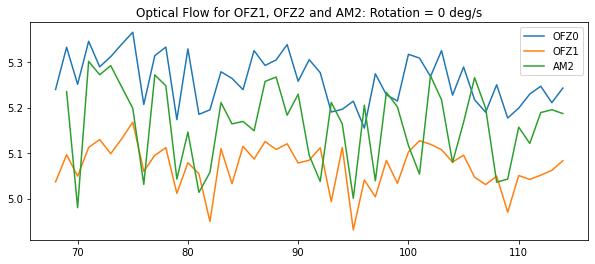

In [179]:
plot_res(res0[45:], 'Optical Flow for OFZ1, OFZ2 and AM2: Rotation = 0 deg/s')

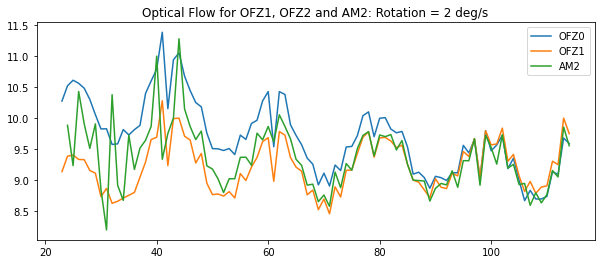

In [180]:
plot_res(res2,'Optical Flow for OFZ1, OFZ2 and AM2: Rotation = 2 deg/s')

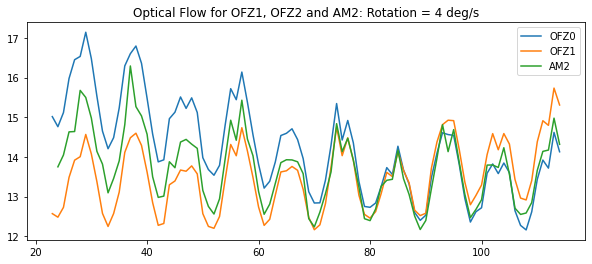

In [181]:
plot_res(res4,'Optical Flow for OFZ1, OFZ2 and AM2: Rotation = 4 deg/s')

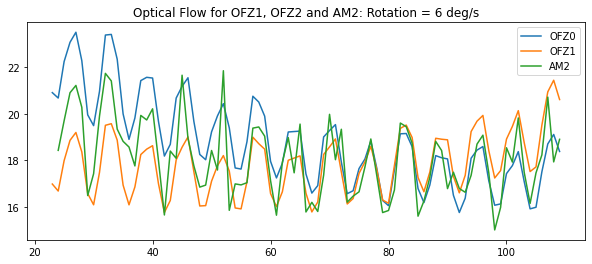

In [182]:
plot_res(res6, 'Optical Flow for OFZ1, OFZ2 and AM2: Rotation = 6 deg/s')

From the above it is clear that the waves are an artifact of the rotation stepper motor cogging.